
# Should i Build a Model around my Heart Rate Performance During Workouts?

### Analysis of workout running data

#### Business Understanding
##### Introduction

I'm a keen runner. I use running as a main mode of exercise and i use it to focus and discipline myself. Despite not being athletic by any means, i enjoy the self-competative aspect to running and being able to always challenege my own performance and ability.

In this blog i will evaluate the last two years performance and stability of heart rate mesurements from my apple watch during workouts. I will use this to determine firstly what patterns can be seen with relation to heart rate and elevation. Using this information i will decide if data modeling would be applicable or if there is too much variation between results.

1) How does my watch perform with heart rate (HR) measurements during workout activities?
- When using the workout app, how many HR measurements does my watch take?
- On average, how long does it take to the first HR measurement.

2) Does elevation have an effect on my running performance in terms of HR?

3) Can this information be used to predict HR during a running activity?

In [23]:
# Import all libraries required for this project

import re, sys, os, datetime
from datetime import datetime
import gpxpy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Datasets:

The datasets i will use will be from:

-1) Apple Health Data - This will be exported from my apple account. The initial export is an xml file so this will need to be prepared in a suitable format to read and analyse. I will pre-prepare this using a different technique and load the data as a csv file. This will still need to be analysed and cleaned to prepare for futher analysis.

-2) Apple Workouts - This will also be exported from my apple account. The workouts which tracks my location by latitude, longitude also plots the elevation. These are exported as .gpx files for each individual workout. These will also need to be prepared and combined into a single format.

### Step 1 - Load and Understand the Data

#### 1.1 Apple Health Data

In [24]:
# Load the dataset
applehealth = pd.read_csv('AppleHealthData.csv', delimiter='|')

# Success - Display the first records
display(applehealth.head(n=10))

,DateTime,Source,HealthType,HealthValue
0,2018-01-09 13:03:37,"Health"" sourceVersion=""11.2.1""",KQuantityTypeIdentifierHeight,5
1,2018-01-11 01:21:00,"Health"" sourceVersion=""11.2.1""",KQuantityTypeIdentifierBodyMass,171
2,2018-02-13 17:31:21,Chris’s Apple,KQuantityTypeIdentifierHeartRate,84
3,2018-02-13 17:37:16,Chris’s Apple,KQuantityTypeIdentifierHeartRate,80
4,2018-02-13 17:44:45,Chris’s Apple,KQuantityTypeIdentifierHeartRate,74
5,2018-02-13 17:53:42,Chris’s Apple,KQuantityTypeIdentifierHeartRate,75
6,2018-02-13 18:00:17,Chris’s Apple,KQuantityTypeIdentifierHeartRate,66
7,2018-02-13 18:27:20,Chris’s Apple,KQuantityTypeIdentifierHeartRate,104
8,2018-02-13 18:29:23,Chris’s Apple,KQuantityTypeIdentifierHeartRate,69
9,2018-02-13 18:29:24,Chris’s Apple,KQuantityTypeIdentifierHeartRate,69


In [25]:
# Visualise the shape of the data.
applehealth.shape

(1524668, 4)

In [26]:
# Identify any missing values by column.
applehealth.isnull().sum()

DateTime       0
Source         0
HealthType     0
HealthValue    0
dtype: int64

In [27]:
# Identify the measurement source types
list(applehealth['Source'].unique())

['Health" sourceVersion="11.2.1"',
 'Chris’s Apple',
 'Chris Hinton’s',
 'Headspace" sourceVersion="13834"',
 'Headspace" sourceVersion="18470"',
 'Headspace" sourceVersion="19905"']

In [28]:
# Only measurement source required is the Apple watch for heart rate measurement. This is found in this list as 'Chris's Apple''
# Only keep apple watch source.
applehealth=applehealth[applehealth['Source'].isin(['Chris’s Apple'])]

In [29]:
# Identify health types.
applehealth['HealthType'].nunique()

15

In [30]:
# Check number of values after with shape.
applehealth.shape

(1418119, 4)

In [31]:
# Review data to understand shape.
applehealth.HealthType.value_counts()

KQuantityTypeIdentifierActiveEnergyBurned          615173
KQuantityTypeIdentifierStepCount                   257489
KQuantityTypeIdentifierBasalEnergyBurned           222283
KQuantityTypeIdentifierDistanceWalkingRunning      149892
KQuantityTypeIdentifierHeartRate                   113938
KQuantityTypeIdentifierAppleExerciseTime            37024
KCategoryTypeIdentifierAppleStandHour                9782
KQuantityTypeIdentifierAppleStandTime                5112
KQuantityTypeIdentifierFlightsClimbed                4751
KQuantityTypeIdentifierHeartRateVariabilitySDNN      1089
KQuantityTypeIdentifierRestingHeartRate               694
KQuantityTypeIdentifierWalkingHeartRateAverage        685
KQuantityTypeIdentifierVO2Max                         181
KCategoryTypeIdentifierMindfulSession                  24
KCategoryTypeIdentifierHighHeartRateEvent               2
Name: HealthType, dtype: int64

In [32]:
# Convert date time field to a date time format
applehealth.DateTime = pd.to_datetime(applehealth.DateTime)
applehealth.dtypes

DateTime       datetime64[ns]
Source                 object
HealthType             object
HealthValue            object
dtype: object

In [33]:
# Dataframe for only heart rate data
all_heartrate = applehealth[applehealth['HealthType'].isin(['KQuantityTypeIdentifierHeartRate'])]

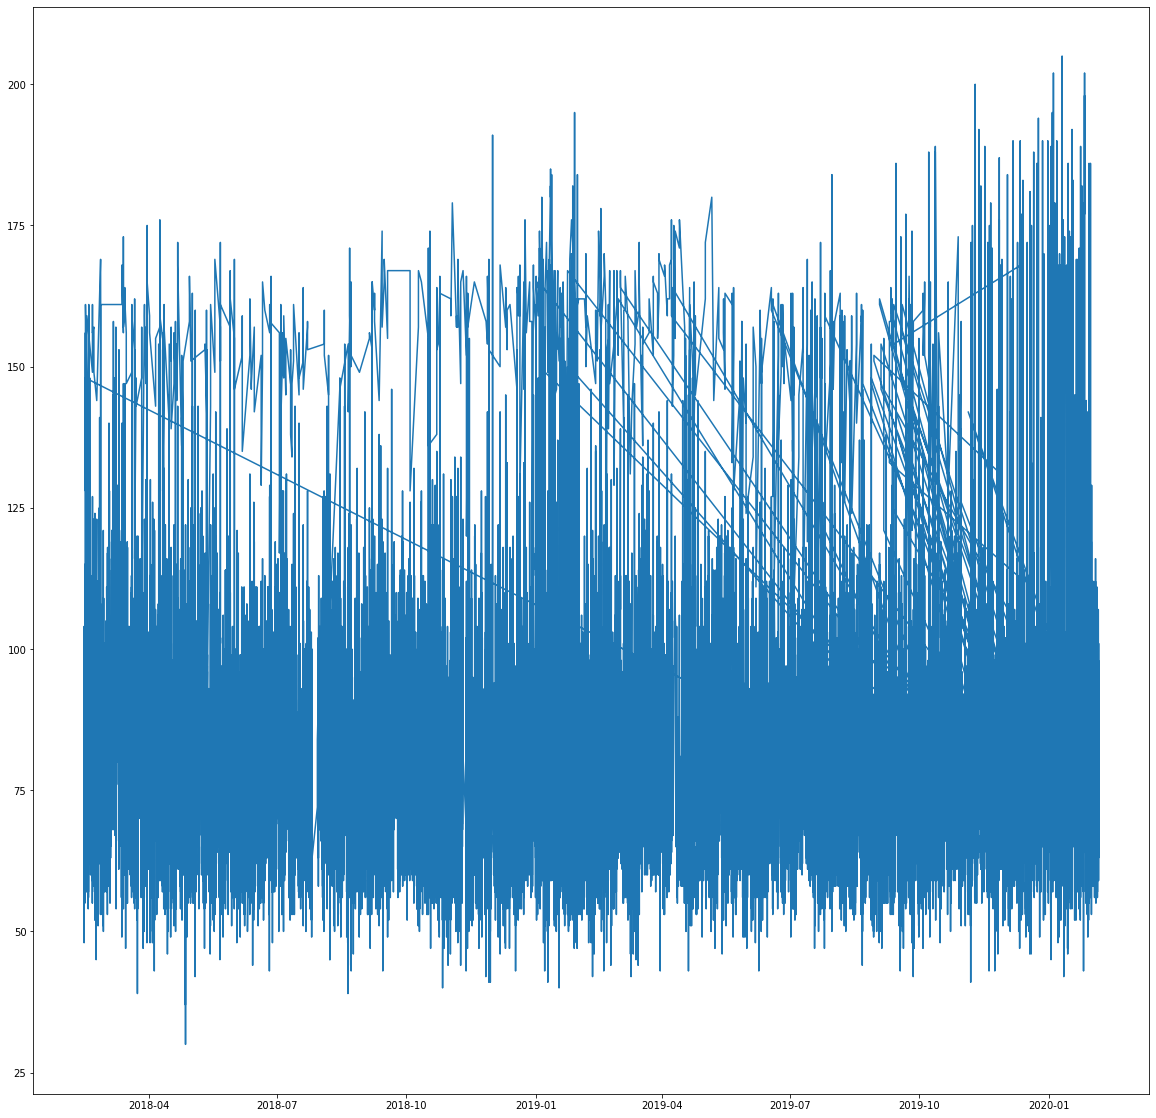

In [34]:
# Visualise all heart rate data
plt.figure(figsize=(20,20))
plt.plot(list(all_heartrate['DateTime']),list(all_heartrate["HealthValue"]))

#### 1.2 GPX Workout Data

After the workout data is exported, each individual workout is split into a single .gpx file.
These need to be parsed, merged and prepared into a single data format to proces. I have carried this out with a separate code so that i can prepare the data separately by removing personal data.

In [36]:
# Checkpoint - Load in combined data
gpx = pd.read_csv('combined_gpxdata.csv', delimiter=',')

In [37]:
# Drop un-required columns (including sensitive information)
gpx = gpx.drop(["Unnamed: 0", "Longitude", "Latitude"],axis=1)

In [38]:
# Visualise header data
gpx.head(n=10)

,Elevation,DateTime,WorkoutNo
0,150.626038,2018-02-20 17:19:56+00:00,1
1,150.449341,2018-02-20 17:19:57+00:00,1
2,150.273361,2018-02-20 17:19:58+00:00,1
3,150.099533,2018-02-20 17:19:59+00:00,1
4,149.930267,2018-02-20 17:20:00+00:00,1
5,149.768890,2018-02-20 17:20:01+00:00,1
6,149.619064,2018-02-20 17:20:02+00:00,1
7,149.484314,2018-02-20 17:20:03+00:00,1
8,149.367783,2018-02-20 17:20:04+00:00,1
9,149.271896,2018-02-20 17:20:04+00:00,1


In [39]:
# Format date time column
gpx.DateTime = pd.to_datetime(gpx.DateTime)

In [40]:
# Format date time to match apple health data
gpx['DateTime']=pd.to_datetime(gpx['DateTime'].dt.strftime('%m/%d/%Y %H:%M:%S'))

In [41]:
# Visualise header data
gpx.head(n=10)

,Elevation,DateTime,WorkoutNo
0,150.626038,2018-02-20 17:19:56,1
1,150.449341,2018-02-20 17:19:57,1
2,150.273361,2018-02-20 17:19:58,1
3,150.099533,2018-02-20 17:19:59,1
4,149.930267,2018-02-20 17:20:00,1
5,149.768890,2018-02-20 17:20:01,1
6,149.619064,2018-02-20 17:20:02,1
7,149.484314,2018-02-20 17:20:03,1
8,149.367783,2018-02-20 17:20:04,1
9,149.271896,2018-02-20 17:20:04,1


In [42]:
# Visualise the shape of the data.
gpx.shape

(531282, 3)

In [44]:
# Identify any missing values by column.
gpx.isnull().sum()

Elevation    0
DateTime     0
WorkoutNo    0
dtype: int64

In [45]:
# Review column formats
gpx.dtypes

Elevation           float64
DateTime     datetime64[ns]
WorkoutNo             int64
dtype: object

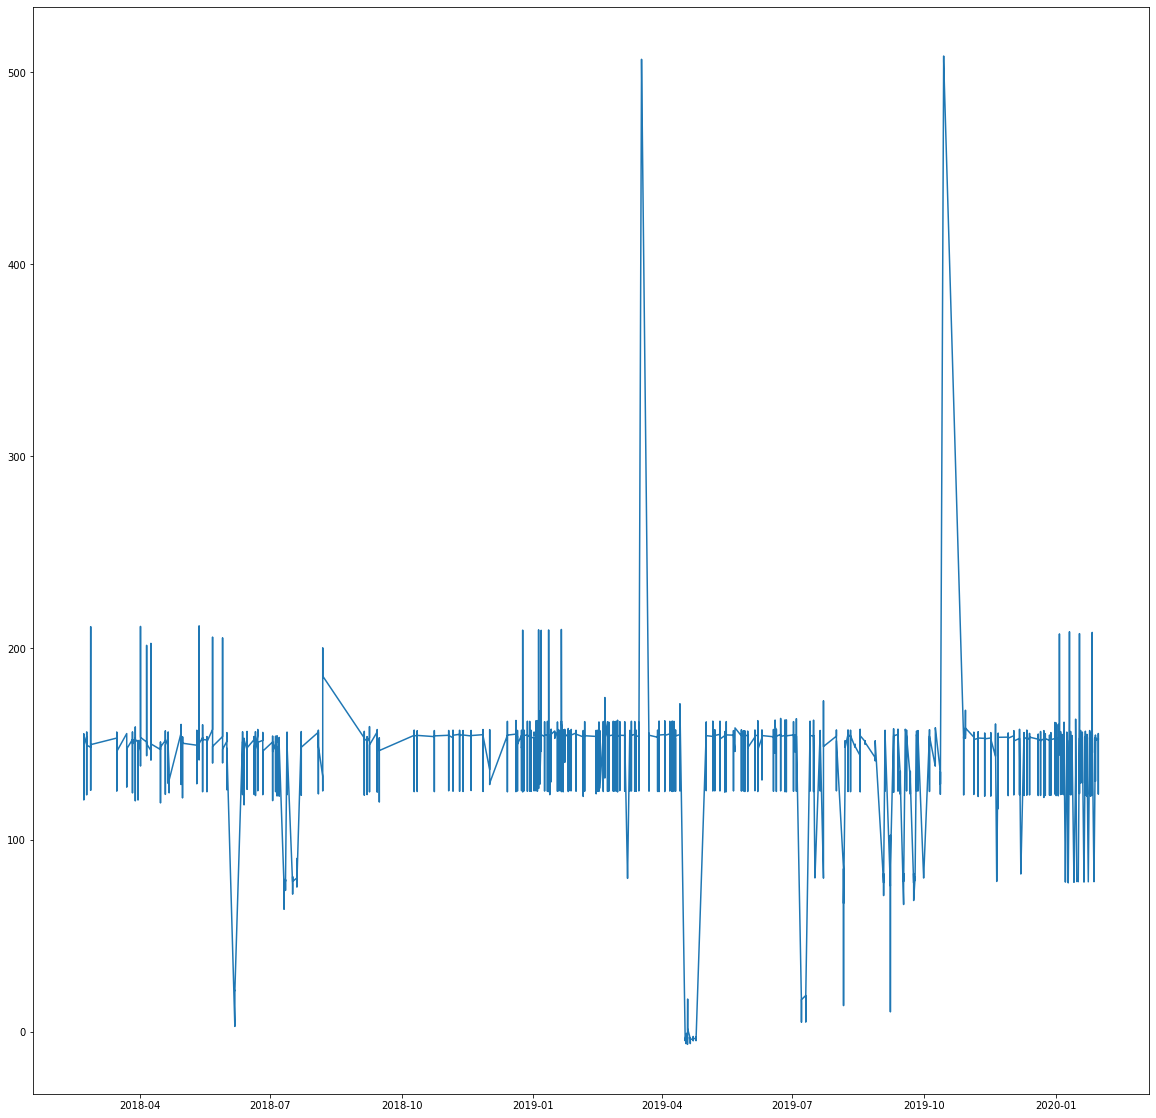

In [46]:
# Visualise all elevation data
plt.figure(figsize=(20,20))
plt.plot(list(gpx['DateTime']),list(gpx["Elevation"]))

### Step 2 - Merge the Datasets

In [47]:
# Function to prepare and merge the data
def appledatamerge (gpx,applehealth):
    applehealth = applehealth[applehealth['Source'].isin(['Chris’s Apple'])]
    merged = pd.merge(applehealth,gpx,on='DateTime',how='left')
    return merged

In [48]:
# Apply function to merge data
merged = appledatamerge(gpx,applehealth)

In [49]:
# Visualise header data
merged.tail(n=10)

,DateTime,Source,HealthType,HealthValue,Elevation,WorkoutNo
1419188,2020-01-28 10:53:16,Chris’s Apple,KQuantityTypeIdentifierHeartRateVariabilitySDNN,49,NaN,NaN
1419189,2020-01-29 14:33:24,Chris’s Apple,KQuantityTypeIdentifierHeartRateVariabilitySDNN,37,NaN,NaN
1419190,2020-01-30 08:44:40,Chris’s Apple,KQuantityTypeIdentifierHeartRateVariabilitySDNN,55,NaN,NaN
1419191,2020-01-31 19:12:57,Chris’s Apple,KQuantityTypeIdentifierHeartRateVariabilitySDNN,43,NaN,NaN
1419192,2020-02-02 09:13:37,Chris’s Apple,KQuantityTypeIdentifierHeartRateVariabilitySDNN,22,NaN,NaN
1419193,2020-02-02 15:18:28,Chris’s Apple,KQuantityTypeIdentifierHeartRateVariabilitySDNN,37,NaN,NaN
1419194,2020-02-03 07:04:03,Chris’s Apple,KQuantityTypeIdentifierHeartRateVariabilitySDNN,25,NaN,NaN
1419195,2020-02-03 07:10:05,Chris’s Apple,KQuantityTypeIdentifierHeartRateVariabilitySDNN,17,NaN,NaN
1419196,2020-02-03 14:33:06,Chris’s Apple,KQuantityTypeIdentifierHeartRateVariabilitySDNN,50,NaN,NaN
1419197,2020-02-05 09:04:49,Chris’s Apple,KQuantityTypeIdentifierHeartRateVariabilitySDNN,48,NaN,NaN


In [50]:
# Identify missing values per column
merged.isnull().sum()

DateTime             0
Source               0
HealthType           0
HealthValue          0
Elevation      1117723
WorkoutNo      1117723
dtype: int64

It appears that the only rows with missing values are when there is no workout tracked. This is additional data not required for this analysis.Therefore, we can drop all rows where there is missing values in Elevation and WorkoutNo. Furthermore, we only want to look at heart rate measurements from the health value column so we can use data with only these identifiers.

In [51]:
# Drop Missing Rows
clean_data = merged.dropna(axis = 0)

In [52]:
# Check data set for remaining missing values
clean_data.isnull().sum()

DateTime       0
Source         0
HealthType     0
HealthValue    0
Elevation      0
WorkoutNo      0
dtype: int64

In [53]:
# Only keep heart rate values from health type.
clean_data = clean_data[clean_data['HealthType'].isin(['KQuantityTypeIdentifierHeartRate'])]

In [54]:
# Visualise data
clean_data.head(n=20)

,DateTime,Source,HealthType,HealthValue,Elevation,WorkoutNo
1604,2018-02-22 18:06:38,Chris’s Apple,KQuantityTypeIdentifierHeartRate,123,149.298996,2.0
7669,2018-04-05 14:45:17,Chris’s Apple,KQuantityTypeIdentifierHeartRate,95,150.955887,10.0
7926,2018-04-08 14:59:19,Chris’s Apple,KQuantityTypeIdentifierHeartRate,102,146.508011,11.0
7927,2018-04-08 15:43:08,Chris’s Apple,KQuantityTypeIdentifierHeartRate,169,149.975067,11.0
9471,2018-04-18 17:28:54,Chris’s Apple,KQuantityTypeIdentifierHeartRate,114,149.650360,13.0
11564,2018-04-30 17:15:28,Chris’s Apple,KQuantityTypeIdentifierHeartRate,125,150.203308,17.0
13592,2018-05-14 18:17:27,Chris’s Apple,KQuantityTypeIdentifierHeartRate,122,152.342422,20.0
14732,2018-05-21 17:35:16,Chris’s Apple,KQuantityTypeIdentifierHeartRate,153,148.661377,22.0
21400,2018-07-07 06:43:13,Chris’s Apple,KQuantityTypeIdentifierHeartRate,130,148.917465,36.0
22190,2018-07-12 18:53:30,Chris’s Apple,KQuantityTypeIdentifierHeartRate,122,148.896927,41.0


In [55]:
# Double check health types column
clean_data.HealthType.value_counts()

KQuantityTypeIdentifierHeartRate    8936
Name: HealthType, dtype: int64

In [56]:
# Calculate the sum of the heart rate measurements per workout
sum_hr_measurements = clean_data.groupby('WorkoutNo')['HealthType'].count().reset_index(name='Counts')
sum_hr_measurements

,WorkoutNo,Counts
0,1.0,3
1,2.0,2
2,3.0,3
3,4.0,2
4,5.0,2
5,6.0,5
6,7.0,2
7,8.0,2
8,9.0,1
9,10.0,3


<Figure size 2160x720 with 0 Axes>

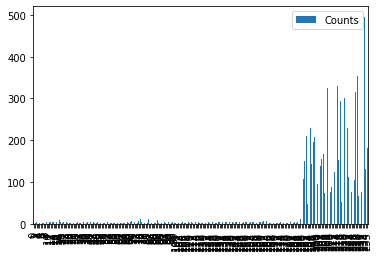

In [57]:
#Visualise the data per measurement
plt.figure(figsize=(30,10))
sum_hr_measurements.plot(kind='bar',y='Counts')

It looks like that despite there being a tracked workout in earlier measurements, there is a big differentce in count of heart rate measurements in earlier measurements. This is because the main apple workout app wasnt used for the original workouts. As a result, i will only use the measurements from workout 202 to 249.

In [58]:
# Draw out the values after workout number 201 which seems to have more HR measurements per workout.
count_above201 = sum_hr_measurements[sum_hr_measurements['WorkoutNo'] >201]

<Figure size 2160x720 with 0 Axes>

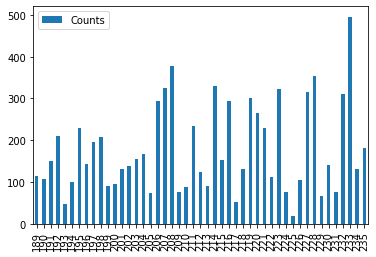

In [59]:
# Visualise this data for workouts above 201
plt.figure(figsize=(30,10))
count_above201.plot(kind='bar',y='Counts')

In [60]:
# Filter the original cleaned & merged dataset by workouts greater than 201.
filtered_workouts = merged.dropna(axis = 0)
filtered_workouts = filtered_workouts[filtered_workouts['WorkoutNo'] >201]
filtered_workouts.head(n=20)

,DateTime,Source,HealthType,HealthValue,Elevation,WorkoutNo
90162,2019-11-12 07:45:56,Chris’s Apple,KQuantityTypeIdentifierHeartRate,148,142.206970,202.0
90163,2019-11-12 07:45:57,Chris’s Apple,KQuantityTypeIdentifierHeartRate,148,142.272110,202.0
90164,2019-11-12 07:46:06,Chris’s Apple,KQuantityTypeIdentifierHeartRate,145,142.067429,202.0
90165,2019-11-12 07:46:10,Chris’s Apple,KQuantityTypeIdentifierHeartRate,145,141.891129,202.0
90166,2019-11-12 07:46:15,Chris’s Apple,KQuantityTypeIdentifierHeartRate,147,141.791779,202.0
90167,2019-11-12 07:46:20,Chris’s Apple,KQuantityTypeIdentifierHeartRate,148,141.680328,202.0
90168,2019-11-12 07:46:26,Chris’s Apple,KQuantityTypeIdentifierHeartRate,150,141.373138,202.0
90169,2019-11-12 07:46:27,Chris’s Apple,KQuantityTypeIdentifierHeartRate,152,141.298019,202.0
90170,2019-11-12 07:46:33,Chris’s Apple,KQuantityTypeIdentifierHeartRate,151,140.840073,202.0
90171,2019-11-12 07:46:41,Chris’s Apple,KQuantityTypeIdentifierHeartRate,153,140.290436,202.0


### Step 3 - Analyse Results

### Question 1 - How does my watch perform with heart rate (HR) measurements during workout activities?

My first approach for this question is to undestand how many hear rate measuerments are taken during a typical workout. To carry out a fair test i will review the duration of workouts to udnestand if i can use a particular workout duration or i need to average number of measurements per minute.

In [61]:
# Return the number of minutes difference
duration = pd.DataFrame(columns=['WorkoutNo', 'Min', 'Max', 'Difference', 'Mins'])
for x in count_above201["WorkoutNo"]:
    workout_minutes = filtered_workouts[filtered_workouts['WorkoutNo'].isin([x])] 
    min=workout_minutes["DateTime"].min()
    max = workout_minutes["DateTime"].max()
    diff = max-min
    mins = diff.total_seconds() / 60
    duration = duration.append({'WorkoutNo':x,'Min':min,'Max': max,'Difference':(max-min),'Mins':mins},ignore_index=True)
duration.head()       

,WorkoutNo,Min,Max,Difference,Mins
0,202.0,2019-11-12 07:39:09,2019-11-12 08:14:53,00:35:44,35.733333
1,203.0,2019-11-16 13:35:25,2019-11-16 14:10:48,00:35:23,35.383333
2,204.0,2019-11-19 20:07:00,2019-11-19 21:08:18,01:01:18,61.300000
3,205.0,2019-11-20 17:35:57,2019-11-20 18:05:49,00:29:52,29.866667
4,206.0,2019-11-21 17:56:50,2019-11-21 18:31:46,00:34:56,34.933333


<Figure size 2160x720 with 0 Axes>

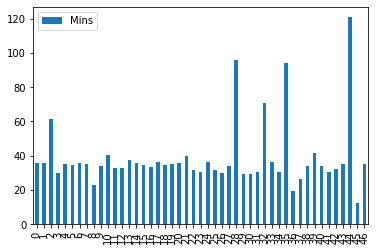

In [62]:
# Plot this data to view range of workout durations
plt.figure(figsize=(30,10))
duration.plot(kind='bar',y='Mins')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002B8ECCFD978>]],
      dtype=object)

<Figure size 2160x720 with 0 Axes>

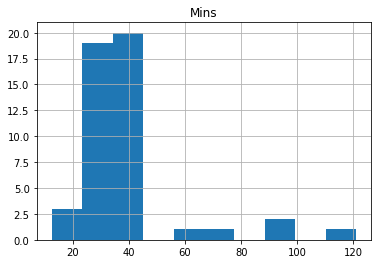

In [63]:
# Visualise it in grouped histogram
plt.figure(figsize=(30,10))
duration.hist(column='Mins')

There are some clear splits between length of run time which could impact the number of heart rate measurements per workout. There is a strong population around 30-40 minutes which covers a majority of the dataset so we can use this rather than using an average per minute.

In [64]:
# Drop rows 
average_30 = duration[(duration['Mins'] >= 25) & (duration['Mins'] <= 50)]
average_30.head()

,WorkoutNo,Min,Max,Difference,Mins
0,202.0,2019-11-12 07:39:09,2019-11-12 08:14:53,00:35:44,35.733333
1,203.0,2019-11-16 13:35:25,2019-11-16 14:10:48,00:35:23,35.383333
3,205.0,2019-11-20 17:35:57,2019-11-20 18:05:49,00:29:52,29.866667
4,206.0,2019-11-21 17:56:50,2019-11-21 18:31:46,00:34:56,34.933333
5,207.0,2019-11-28 17:47:49,2019-11-28 18:22:33,00:34:44,34.733333


In [65]:
# Count number of measurements per workout

measurements_count = pd.DataFrame(columns=['WorkoutNo', 'Count'])
for x in average_30["WorkoutNo"]:
    filter_hr = filtered_workouts[filtered_workouts['HealthType'].isin(['KQuantityTypeIdentifierHeartRate'])]
    counts = 0
    filter_workout = filter_hr[filter_hr['WorkoutNo'].isin([x])] 
    countval = filter_workout["WorkoutNo"].count()
    measurements_count = measurements_count.append({'WorkoutNo': x, 'Count' :countval}, ignore_index=True)
measurements_count.head()

,WorkoutNo,Count
0,202.0,115.0
1,203.0,106.0
2,205.0,211.0
3,206.0,48.0
4,207.0,100.0


<Figure size 2160x720 with 0 Axes>

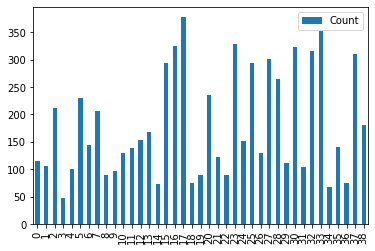

In [66]:
# Plot the counts of heart rate measurements on a histogram
plt.figure(figsize=(30,10))
measurements_count.plot(kind='bar',y='Count')

In [67]:
# Find the mean of these results
measurements_count[['Count']].mean()

Count    181.307692
dtype: float64

We can see that where the data is stored in the correct format, the heart rate measurements fluctuate quite significantly through each workout. This data could cause reduce the level of accuracy we could gain from using predictive modelling.

The second point to address this question is how long until my watch makes the first heart rate measurement above 130bpm. (I chose 130 because i expect to workout at roughly 70% of my max heart rate.

In [69]:
# Return the number of minutes difference between start and first HR measurement
hr_starttime = pd.DataFrame(columns=['WorkoutNo', 'Min', 'Max', 'Difference', 'Mins'])
for x in count_above201["WorkoutNo"]:
    filter_workout = merged[merged['WorkoutNo'].isin([x])] 
    workout_start = filter_workout["DateTime"].min()
    filter_hr = filter_workout[filter_workout['HealthType'].isin(['KQuantityTypeIdentifierHeartRate'])]
    filter_hr['HealthValue'] = filter_hr['HealthValue'].astype(float)
    filter_hr = filter_hr[filter_hr['HealthValue']>130]
    hr_start = filter_hr["DateTime"].min()
    diff = hr_start-workout_start
    mins2 = diff.total_seconds() / 60
    hr_starttime = hr_starttime.append({'WorkoutNo': x, 'Min' : workout_start, 'Max' : max, 'Difference' : diff, 'Mins' : mins2}, ignore_index=True)
hr_starttime.head() 


C:\Users\qt54112\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,WorkoutNo,Min,Max,Difference,Mins
0,202.0,2019-11-12 07:39:09,2020-01-30 18:07:06,00:06:47,6.783333
1,203.0,2019-11-16 13:35:25,2020-01-30 18:07:06,00:00:52,0.866667
2,204.0,2019-11-19 20:07:00,2020-01-30 18:07:06,00:12:54,12.900000
3,205.0,2019-11-20 17:35:57,2020-01-30 18:07:06,00:00:40,0.666667
4,206.0,2019-11-21 17:56:50,2020-01-30 18:07:06,00:00:42,0.700000


<Figure size 2160x720 with 0 Axes>

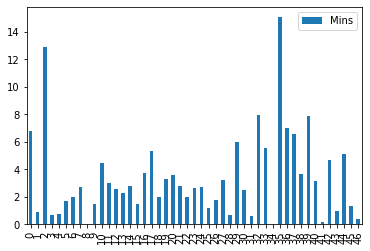

In [70]:
#Plot results on histogram
plt.figure(figsize=(30,10))
hr_starttime.plot(kind='bar',y='Mins')

In [71]:
#Run some stats on min and max and average
print(hr_starttime["Mins"].mean())
print(hr_starttime["Mins"].min())
print(hr_starttime["Mins"].max())

3.463405797101449
0.016666666666666666
15.066666666666666


Here we can see that again there is quite alot of variation between the start of a workout and the first heart rate measurement. This could also cause potential error for further modelling.

Q1 Answer - The watch heart rate measurements produces too much variation across both number of measurements and start time of first expected measurement above 130bpm. 

In [72]:
# Draw out a single workout to understand dataset
single_workout = merged[merged['WorkoutNo'].isin(['249'])]

In [73]:
# Sum missing values within a workout.
single_workout.isnull().sum()

DateTime       0
Source         0
HealthType     0
HealthValue    0
Elevation      0
WorkoutNo      0
dtype: int64

### Question 2 - Does elevation have an effect on my running performance in terms of HR?

My approach to this question is to visualise a number of plots by combining line plots with both elevation and heart rate.

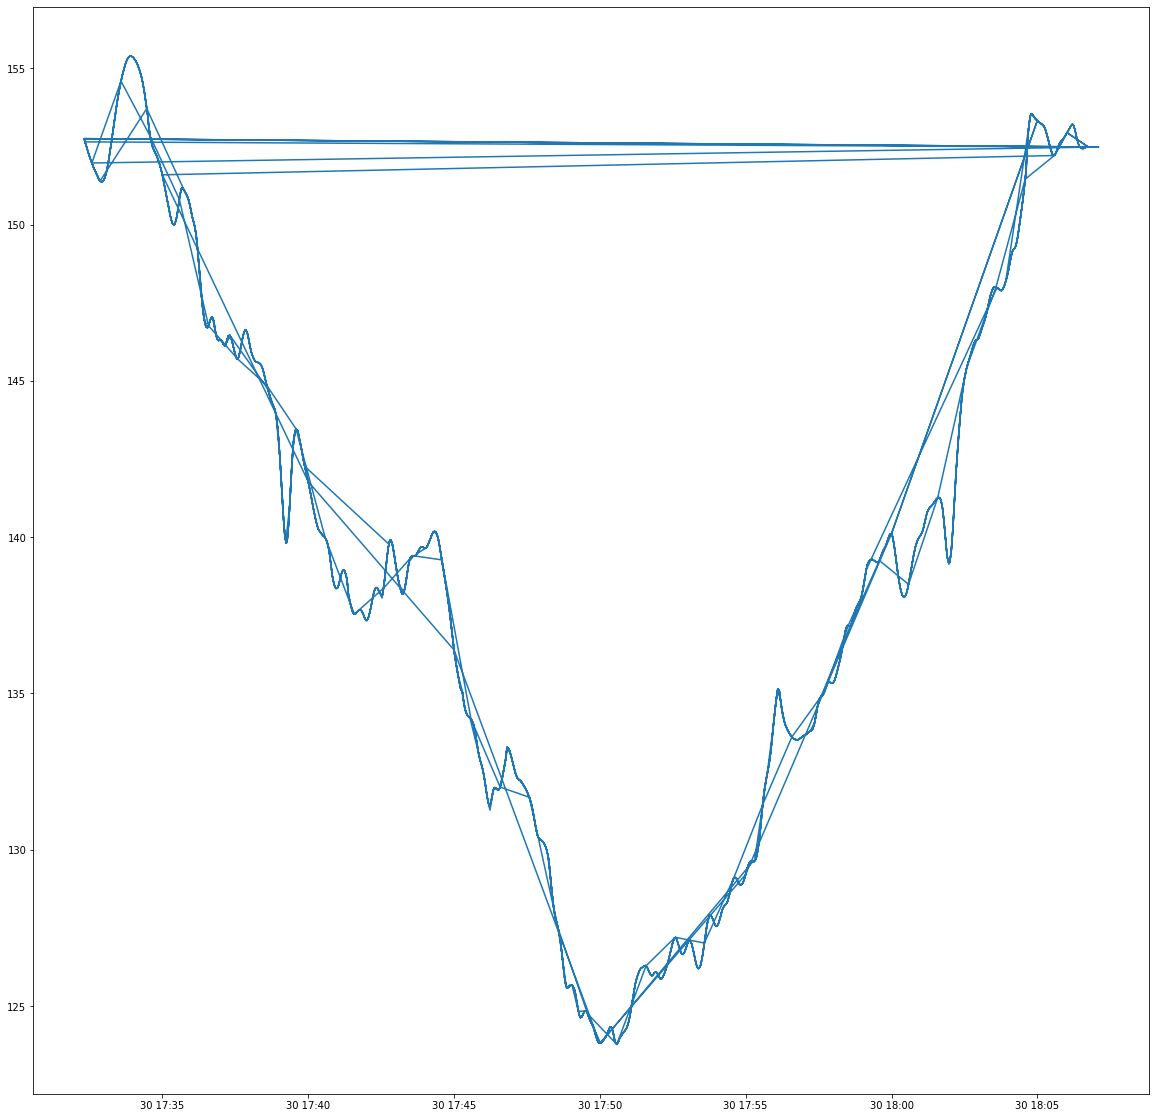

In [74]:
# Visualise a single elevation path
plt.figure(figsize=(20,20))
plt.plot(list(single_workout['DateTime']),list(single_workout["Elevation"]))

In [75]:
# Filter dataset by heartrate
filter_hr = single_workout[single_workout['HealthType'].isin(['KQuantityTypeIdentifierHeartRate'])]

In [76]:
# Produce a random list of workout numbers to analyse
random_list = (202,203,204,205,206,207,210,215,220,230,241,249)

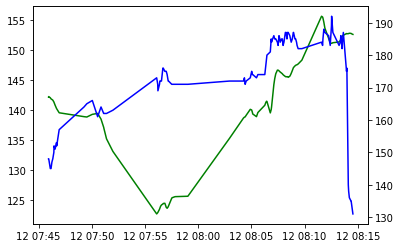

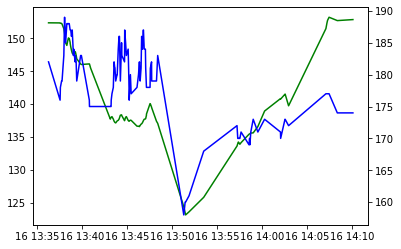

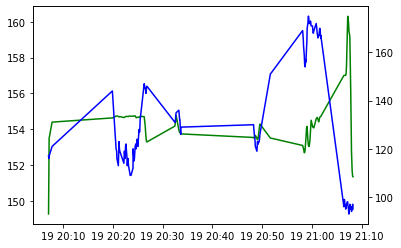

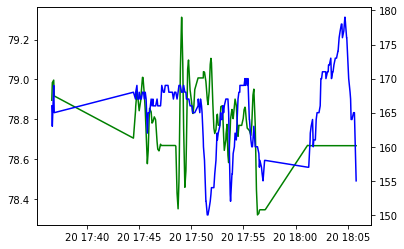

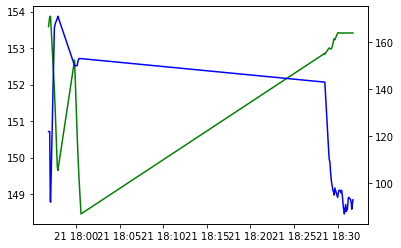

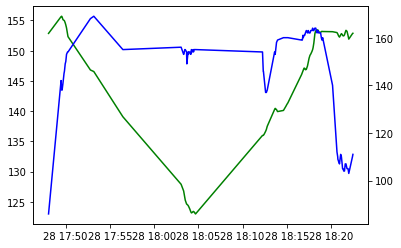

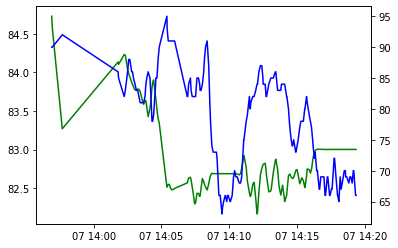

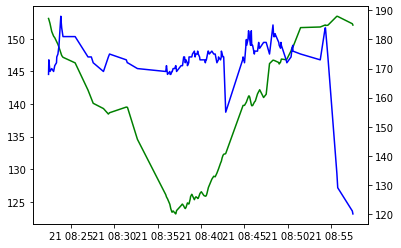

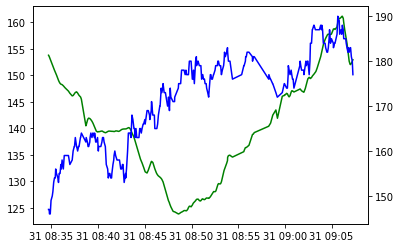

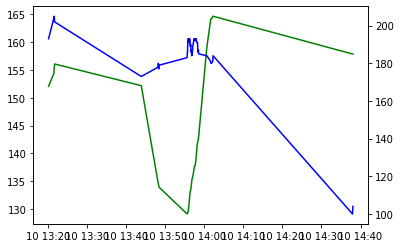

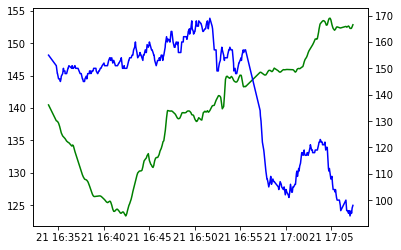

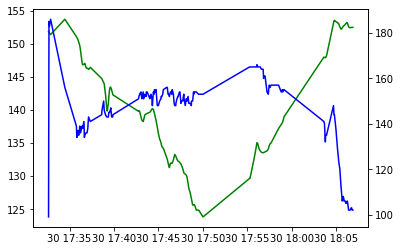

In [77]:
hr_starttime = pd.DataFrame(columns=['WorkoutNo', 'Min', 'Max', 'Difference', 'Mins'])
for x in random_list:
    filter_workout = merged[merged['WorkoutNo'].isin([x])] 
    filter_hr = filter_workout[filter_workout['HealthType'].isin(['KQuantityTypeIdentifierHeartRate'])]
    fig, ax1 = plt.subplots()
    x = filter_hr['DateTime']
    y1 = filter_hr['Elevation']
    y2 = filter_hr['HealthValue']
    ax2 = ax1.twinx()
    ax1.plot(x, y1, 'g-')
    ax2.plot(x, y2, 'b-')

There are some charts above which shows interesting correlations between heart rate and elevation. In some cases it appears my heart rate is highest when elevation is lowest.

Q2 Answer - Yes in some cases we can see patterns or correlations between the two measurements heart rate and elevation.

### Question 3 - Can this information be used to predict HR during a running activity?

The results from the analysis shows that of the data i have collected over the last two years, i can only really gain a reliable analsis from 19% of the measurements (workouts 202-249). This drastically reduced the number of results i can use to train a model around this data.

The second element is that the results in the HR and elevation comparison show significant differences, and in some cases, polar opposite expections of performance. When i drill analyse this deeper there can be additional variables which potentially has an influence such as time of day:

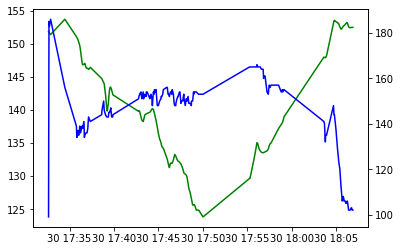

In [78]:
# Afternoon workout number 249
filter_workout = merged[merged['WorkoutNo'].isin([249])] 
filter_hr = filter_workout[filter_workout['HealthType'].isin(['KQuantityTypeIdentifierHeartRate'])]
fig, ax1 = plt.subplots()
x = filter_hr['DateTime']
y1 = filter_hr['Elevation']
y2 = filter_hr['HealthValue']
ax2 = ax1.twinx()
ax1.plot(x, y1, 'g-')
ax2.plot(x, y2, 'b-')

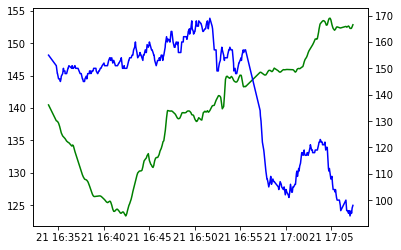

In [79]:
# Afternoon workout number 241
filter_workout = merged[merged['WorkoutNo'].isin([241])] 
filter_hr = filter_workout[filter_workout['HealthType'].isin(['KQuantityTypeIdentifierHeartRate'])]
fig, ax1 = plt.subplots()
x = filter_hr['DateTime']
y1 = filter_hr['Elevation']
y2 = filter_hr['HealthValue']
ax2 = ax1.twinx()
ax1.plot(x, y1, 'g-')
ax2.plot(x, y2, 'b-')

Although the second chart (workout 241) starts off initially with an increasing HR, it goes completely the opposite direction when the elevation rises.

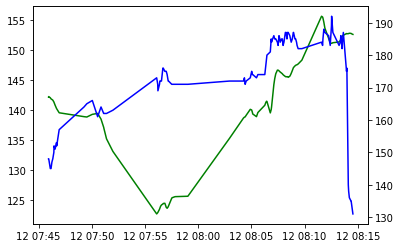

In [80]:
# Afternoon workout number 202
filter_workout = merged[merged['WorkoutNo'].isin([202])] 
filter_hr = filter_workout[filter_workout['HealthType'].isin(['KQuantityTypeIdentifierHeartRate'])]
fig, ax1 = plt.subplots()
x = filter_hr['DateTime']
y1 = filter_hr['Elevation']
y2 = filter_hr['HealthValue']
ax2 = ax1.twinx()
ax1.plot(x, y1, 'g-')
ax2.plot(x, y2, 'b-')

Here we see a workout which was carried out at a different time of the day (morning). Here shows a higher heart rate performance in general for the same elevation and also a more expected increasing condition.

Q3 Answer - Based on this analysis i believe that there are many other variables which need to be taken into consideration before training a model to gain any kind of accuracy. To improve this for further analysis i should take the following potential variables into account:
- Time of day
- Weather
- Last feed e.g digestion / amount of energy
- No of previous workouts within time/day range
- Speed of running

Futhermore i should produce a dataset which outputs the distance from HR to elevation and plot this to see how it looks across workouts in the same time frame.